
# Coupon Dataset — Exploratory Data Analysis (EDA)

This notebook runs 3 EDA steps for the Ralphs coupon dataset (`ralphs_coupons_clean.csv` or `all_coupons.json`):

1) Offer Distribution Analysis
2) Expiration & Validity Analysis
3) Text Similarity & Keyword Frequency Analysis

> Charts use **matplotlib** (no seaborn).


In [1]:
import json
import re
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Lightweight lemmatizer (no external downloads)
VOWELS = set("aeiou")

def lemmatize_token(tok: str) -> str:
    w = tok.lower()
    if w.endswith("'s"):
        w = w[:-2]
    if len(w) > 4 and w.endswith("ies"):        # cookies -> cookie
        return w[:-3] + "y"
    if len(w) > 4 and w.endswith("es") and any(w.endswith(suf) for suf in ("ses","xes","zes","ches","shes")):
        return w[:-2]                            # boxes -> box, dishes -> dish
    if len(w) > 3 and w.endswith("s") and not w.endswith("ss"):
        w = w[:-1]                               # eggs -> egg, headphones -> headphone
    if len(w) > 4 and w.endswith("ed"):
        w = w[:-2]                               # baked -> bake
    if len(w) > 5 and w.endswith("ing"):        # running -> run, baking -> bake
        base = w[:-3]
        if len(base) >= 3 and base[-1] not in VOWELS and base[-2] == base[-1]:
            base = base[:-1]
        if len(base) >= 2 and base[-1] not in VOWELS:
            base = base + "e"
        return base
    return w

STOPWORDS = {
    "the","a","an","with","and","or","for","to","of","on","off","by","from","at","in","per","each","every",
    "black","white","red","blue","green","xl","l","m","s","pack","oz","ct","size","new","save","coupon","offer",
    "st"   # Simple Truth abbrev
}

def tokenize_lemma(s: str):
    toks = re.findall(r"[A-Za-z0-9]{2,}", (s or "").lower())
    return [lemmatize_token(t) for t in toks if t not in STOPWORDS]

def sanitize_text(desc: str) -> str:
    s = (desc or "")
    s = re.sub(r"\$\s*\d+(?:[.,]\d+)?", " ", s)                                # $3, $3.00
    s = re.sub(r"\b\d+\s*/\s*\$\s*\d+(?:[.,]\d+)?", " ", s)                    # 2/$5
    s = re.sub(r"\b\d+\s*(?:for|4)\s*\$\s*\d+(?:[.,]\d+)?", " ", s, flags=re.I)# 3 for $10
    s = re.sub(r"\b\d+(?:[.,]\d+)?\s*%|\b\d+(?:[.,]\d+)?\s*percent\b", " ", s, flags=re.I)
    s = re.sub(r"\b\d+(?:[.,]\d+)?\b", " ", s)                                 # standalone numbers
    s = re.sub(r"\s+", " ", s).strip()
    return s

def coerce_float(x):
    try:
        if isinstance(x, str):
            x = x.replace("$", "").replace(",", "").strip()
        return float(x)
    except Exception:
        return None


In [2]:
JSON_PATH = Path("/Users/arrju/Documents/CS595/txn-category-ml/data/coupons.json")

def flatten_coupon(raw: dict) -> dict:
    d = dict(raw)
    for key in ("coupon","offer","attributes"):
        if isinstance(d.get(key), dict):
            d = {**d, **d[key]}
    def _first(keys, default=""):
        for k in keys:
            if k in d and d[k]:
                return d[k]
        return default
    return {
        "id": str(_first(["id","couponId","coupon_id","offerId","offer_id","sku"], "")),
        "title": str(_first(["title","name","description","shortDescription"], "")),
        "brand": str(_first(["brand","brandName","brand_name","manufacturer"], "")),
        "category": str(_first(["category","categoryName","department","dept"], "")),
        "discount": _first(["discount","savings","amount","value","offerAmount","offer_value","price","reward"], ""),
        "expires_raw": str(_first(["expires","expiration","expirationDate","endDate","end_date","valid_to"], "")),
        "displayDescription": str(_first(["displayDescription"], "")),
        "shortDescription": str(_first(["shortDescription"], "")),
        "longDescription": str(_first(["longDescription","long_description","fullDescription"], "")),
        "store": str(_first(["store","retailer","retailerName"], "Ralphs")),
    }

def load_coupons():
    if JSON_PATH.exists():
        data = json.loads(JSON_PATH.read_text(encoding="utf-8"))
        if isinstance(data, dict):
            for key in ["coupons","data","offers","items","results","list","records"]:
                if key in data and isinstance(data[key], list):
                    items = data[key]
                    break
            else:
                lists = [v for v in data.values() if isinstance(v, list)]
                items = lists[0] if lists else [data]
        elif isinstance(data, list):
            items = data
        else:
            items = []
        rows = [flatten_coupon(x) for x in items]
        return pd.DataFrame(rows).fillna("")
    else:
        raise FileNotFoundError("Place ralphs_coupons_clean.csv or all_coupons.json in /mnt/data")

df = load_coupons()
print(f"Loaded coupons: {len(df):,}")
df.head(3)


Loaded coupons: 537


,id,title,brand,category,discount,expires_raw,displayDescription,shortDescription,longDescription,store
0,4112346,4X Fuel Points,Kroger Brand,,4.0,2025-11-01T03:59:59Z,,FRI ONLY 4X Fuel Points on Purchases on 10/31 ...,,Ralphs
1,4141260,4X Fuel Points,Other,,4.0,2025-11-05T04:59:59Z,,Get 4x FUEL POINTS,*CARDS HAVE NO VALUE UNTIL ACTIVATED. TERMS AN...,Ralphs
2,4128048,4X Fuel Points,MasterCard,,4.0,2025-11-05T04:59:59Z,,Get 4x FUEL POINTS,Offer excludes Mastercard® and/or Visa® variab...,Ralphs


Prepare Fields for EDA

In [3]:
def parse_title_offer(title: str, discount_field: str):
    t = (title or "").strip()
    d = (discount_field or "").strip()
    # % in title
    pct_t = re.search(r"(\d+(?:\.\d+)?)\s*[%％]", t)
    if pct_t:
        return "save_pct", float(pct_t.group(1))
    # starts with "Save"
    if t.lower().startswith("save"):
        m = re.search(r"(\d+(?:\.\d{1,2})?)", t)
        if m:
            return "save", float(m.group(1))
        val = coerce_float(d)
        if val is not None:
            return "save", val
        return "save", None
    # plain $X → treat as save X
    m = re.search(r"\$?\s*(\d+(?:\.\d{1,2})?)", t)
    if m:
        return "save", float(m.group(1))
    return None, None

df = df.copy()
parsed = [parse_title_offer(t, str(d)) for t, d in zip(df["title"], df["discount"].astype(str))]
df["offer_type"]   = [p[0] for p in parsed]
df["offer_amount"] = [p[1] for p in parsed]
df["discount_num"] = df["discount"].apply(coerce_float)

def choose_amount(row):
    if row["offer_type"] == "save_pct":
        return row["offer_amount"]
    if row["offer_type"] == "save":
        return row["discount_num"] if row["discount_num"] is not None else row["offer_amount"]
    return row["offer_amount"]

df["offer_amount_final"] = df.apply(choose_amount, axis=1)

# Sanitize descriptive fields and build a unified text column
df["displayDescription_san"] = df["displayDescription"].apply(sanitize_text)
df["shortDescription_san"]   = df["shortDescription"].apply(sanitize_text)
df["longDescription_san"]    = df["longDescription"].apply(sanitize_text)

df["match_text"] = (
    df["brand"].astype(str) + " " + df["title"].astype(str) + " " + df["category"].astype(str) + " " +
    df["displayDescription_san"].astype(str) + " " + df["shortDescription_san"].astype(str) + " " +
    df["longDescription_san"].astype(str)
).str.strip()

df[["title","brand","category","offer_type","offer_amount_final","expires_raw"]].head(5)


,title,brand,category,offer_type,offer_amount_final,expires_raw
0,4X Fuel Points,Kroger Brand,,save,4.0,2025-11-01T03:59:59Z
1,4X Fuel Points,Other,,save,4.0,2025-11-05T04:59:59Z
2,4X Fuel Points,MasterCard,,save,4.0,2025-11-05T04:59:59Z
3,$10.00 off $75.00 + Free Delivery on Your Next...,Other,,save,10.0,2025-11-09T04:59:59Z
4,4X Fuel Points,Private Selection,,save,4.0,2025-11-05T04:59:59Z


Offer Distribution (plots + quick tables)

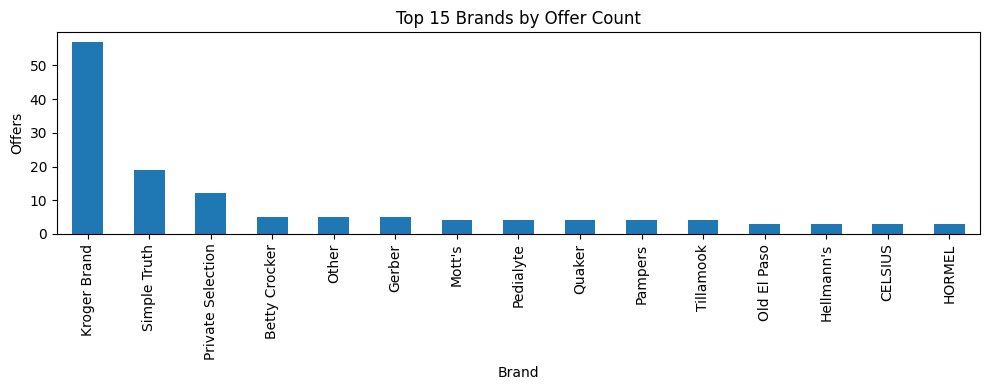

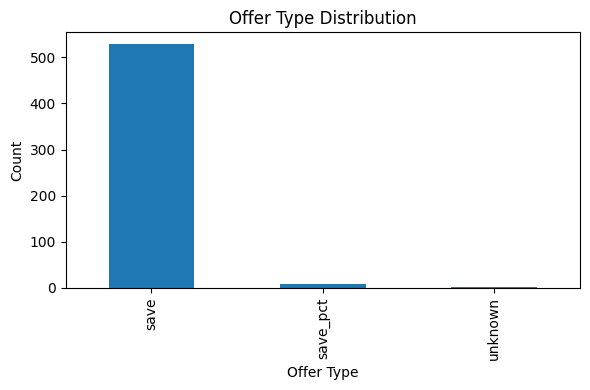

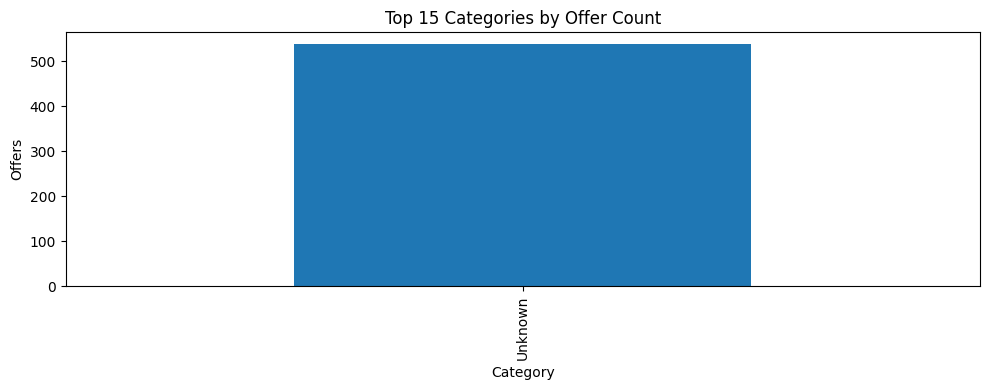

,n
brand,
Kroger Brand,57
Simple Truth,19
Private Selection,12
Betty Crocker,5
Other,5
Gerber,5
Mott's,4
Pedialyte,4
Quaker,4


In [4]:
# Top brands
brand_counts = df['brand'].replace('', 'Unknown').value_counts().head(15)
ax = brand_counts.plot(kind='bar', figsize=(10,4), title='Top 15 Brands by Offer Count')
ax.set_xlabel('Brand'); ax.set_ylabel('Offers')
plt.tight_layout(); plt.show()

# Offer types
offer_type_counts = df['offer_type'].fillna('unknown').value_counts()
ax = offer_type_counts.plot(kind='bar', figsize=(6,4), title='Offer Type Distribution')
ax.set_xlabel('Offer Type'); ax.set_ylabel('Count')
plt.tight_layout(); plt.show()

# Categories
cat_counts = df['category'].replace('', 'Unknown').value_counts().head(15)
ax = cat_counts.plot(kind='bar', figsize=(10,4), title='Top 15 Categories by Offer Count')
ax.set_xlabel('Category'); ax.set_ylabel('Offers')
plt.tight_layout(); plt.show()

# Optional: show as DataFrames
brand_counts.to_frame("n").head(15)


Expiry distribution & weekly counts

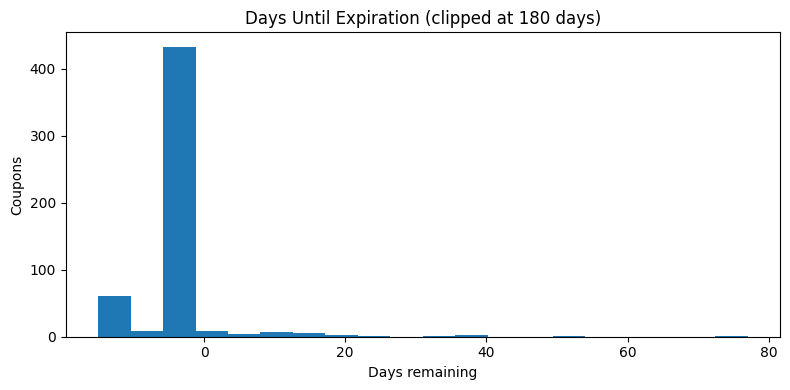

/var/folders/0w/ylpyfvqd6hj8rwzzyt_d57yh0000gn/T/ipykernel_34531/1767431682.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  week = expires.dt.to_period('W').astype(str)


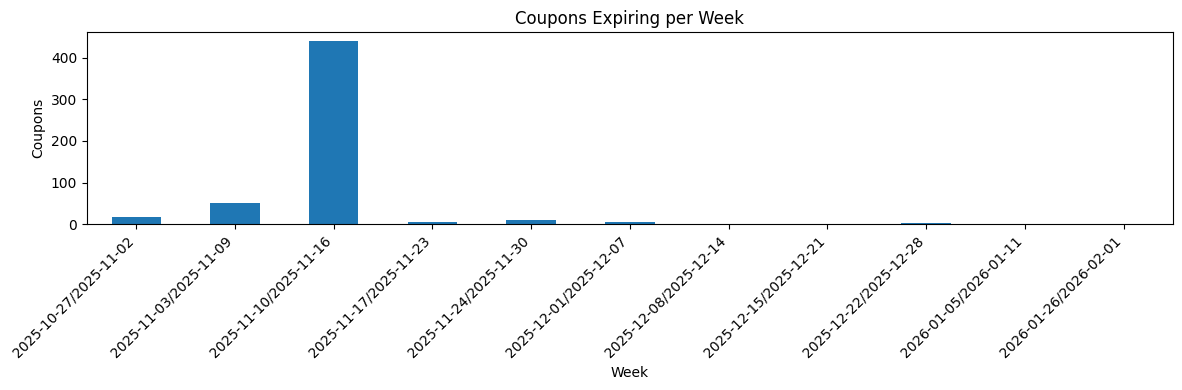

,total_coupons,known_expiry,median_days_left,mean_days_left
0,537,537,-4.0,-3.756052


In [5]:
expires = pd.to_datetime(df['expires_raw'], errors='coerce', utc=True)
today = pd.Timestamp.now(tz='UTC').normalize()
days_left = (expires - today).dt.days

# Days to expiry (clip at 180 for visibility)
ax = days_left[expires.notna()].clip(upper=180).plot(
    kind='hist', bins=20, figsize=(8,4), title='Days Until Expiration (clipped at 180 days)'
)
ax.set_xlabel('Days remaining'); ax.set_ylabel('Coupons')
plt.tight_layout(); plt.show()

# Weekly expirations
week = expires.dt.to_period('W').astype(str)
exp_by_week = week[expires.notna()].value_counts().sort_index()
ax = exp_by_week.plot(kind='bar', figsize=(12,4), title='Coupons Expiring per Week')
ax.set_xlabel('Week'); ax.set_ylabel('Coupons')
plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.show()

# Summary stats
summary = pd.DataFrame({
    'total_coupons': [len(df)],
    'known_expiry': [expires.notna().sum()],
    'median_days_left': [days_left[expires.notna()].median()],
    'mean_days_left': [days_left[expires.notna()].mean()]
})
summary


Text Similarity & Keyword Frequency
Token lengths & top tokens

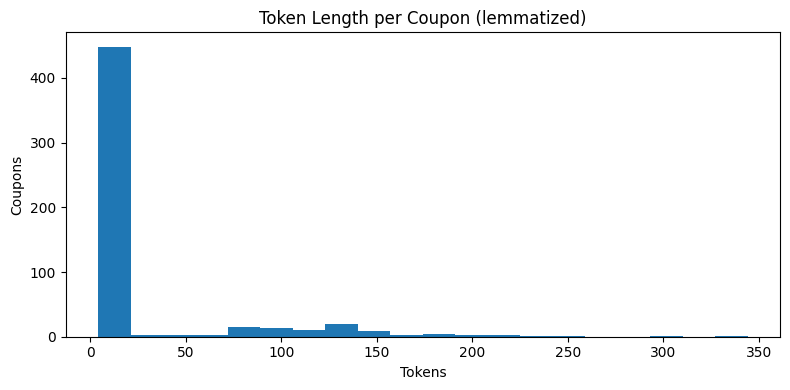

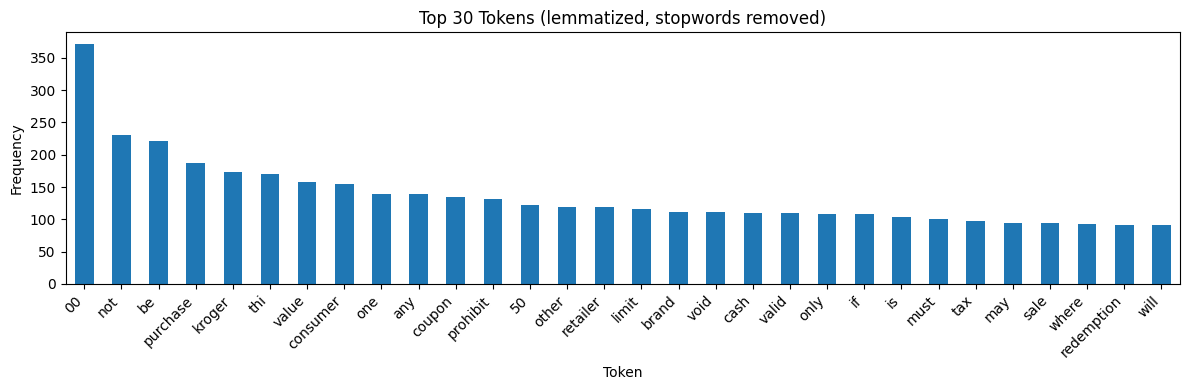

,token,frequency
0,00,371
1,not,230
2,be,221
3,purchase,188
4,kroger,174
5,thi,170
6,value,158
7,consumer,155
8,one,140
9,any,139


In [6]:
tokens_series = df['match_text'].astype(str).apply(tokenize_lemma)

# Text length distribution (number of tokens per coupon)
lengths = tokens_series.apply(len)
ax = lengths.plot(kind='hist', bins=20, figsize=(8,4), title='Token Length per Coupon (lemmatized)')
ax.set_xlabel('Tokens'); ax.set_ylabel('Coupons')
plt.tight_layout(); plt.show()

# Top tokens (global frequency)
freq = Counter()
for toks in tokens_series:
    freq.update(toks)

top_tokens = pd.Series(dict(freq.most_common(30)))
ax = top_tokens.plot(kind='bar', figsize=(12,4), title='Top 30 Tokens (lemmatized, stopwords removed)')
ax.set_xlabel('Token'); ax.set_ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.show()

top_tokens.reset_index().rename(columns={'index':'token', 0:'frequency'})
